In [3]:
import os
os.chdir("/Users/pasqualinodipilla/multimodal-synthetic-biomedical")
os.getcwd()

'/Users/pasqualinodipilla/multimodal-synthetic-biomedical'

In [4]:
#import e caricamento dataset preprocessato
import numpy as np
import matplotlib.pyplot as plt

data = np.load("data/parkinson/processed/parkinson_T6_motor_UPDRS.npz", allow_pickle=True)

X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]
feature_cols = list(data["feature_cols"])

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4475, 6, 20), (4475,), (1190, 6, 20), (1190,))

In [5]:
#guardo una sequenza , un campione per la gru
i = 0 #cambio indice per vedere altre sequenze
seq = X_train[i] # (6,20)
target = y_train[i] # scalar

print("Sequence shape:", seq.shape)
print("Target motor_UPDRS", target)

Sequence shape: (6, 20)
Target motor_UPDRS 29.435


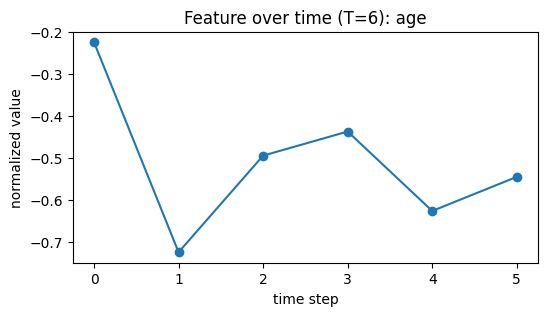

In [8]:
#segliamo una feature e guardiamola sui 6 time-step
feat_name = feature_cols[0]
j=5 #indice feature

plt.figure(figsize=(6,3))
plt.plot(seq[:,j], marker="o")
plt.title(f"Feature over time (T=6): {feat_name}")
plt.xlabel("time step")
plt.ylabel("normalized value")
plt.show()

In [9]:
#setup pytorch e dataloader
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [10]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_ds = SeqDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

In [11]:
#definisco una gru piccola
class GRURegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.head = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1,:]
        return self.head(last).squeeze(-1)
    
model = GRURegressor(input_dim=X_train.shape[-1], hidden_dim=32).to(device)
model

GRURegressor(
  (gru): GRU(20, 32, batch_first=True)
  (head): Linear(in_features=32, out_features=1, bias=True)
)

In [12]:
#predizione prima del training (random)
with torch.no_grad():
    x = torch.tensor(X_train[:8], dtype=torch.float32).to(device)
    preds = model(x).cpu().numpy()

print("Preds (untrained):", np.round(preds, 2))
print("True:", np.round(y_train[:8], 2))

Preds (untrained): [-0.19 -0.17 -0.2  -0.15 -0.14 -0.17 -0.21 -0.18]
True: [29.44 29.68 29.93 30.18 30.42 30.67 30.92 31.31]


In [15]:
#faccio 1-2 epoche e vediamo come migliora
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

model.train()
for epoch in range(2): #2 epoche solo per vedere il meccanismo
    total = 0
    for Xb, yb in train_loader:
        Xb =Xb.to(device)
        yb = yb.to(device)

        opt.zero_grad()
        yhat = model(Xb)
        loss = loss_fn(yhat, yb)
        loss.backward()
        opt.step()

        total += loss.item() * Xb.size(0)
    
    print(f"Epoch {epoch+1}: train MSE = {total / len(train_ds):.4f}")

Epoch 1: train MSE = 99.2169
Epoch 2: train MSE = 75.3984


In [16]:
#predizione dopo training
model.eval()
with torch.no_grad():
    x = torch.tensor(X_train[:8], dtype=torch.float32).to(device)
    preds2 = model(x).cpu().numpy()

print("Preds (after 2 epochs):", np.round(preds2,2))
print("True:", np.round(y_train[:8], 2))

Preds (after 2 epochs): [18.98 18.98 18.99 18.99 18.99 18.99 18.99 18.99]
True: [29.44 29.68 29.93 30.18 30.42 30.67 30.92 31.31]


In [17]:
#mini metrica su un pezzetto di test
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
with torch.no_grad():
    xt = torch.tensor(X_test[:512], dtype=torch.float32).to(device)
    yh = model(xt).cpu().numpy()

yt = y_test[:512]
print("MSE:", mean_squared_error(yt, yh))
print("MAE:", mean_absolute_error(yt, yh))
print("R2 :", r2_score(yt, yh))

MSE: 54.85789108276367
MAE: 5.466627597808838
R2 : 0.22052538394927979
